In [5]:
import pandas as pd
from pathlib import Path
import yfinance as yf
import numpy as np
import csv
import matplotlib.pyplot as plt
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

In [2]:
df_50 = pd.read_csv(
    Path("./Data/QM_50_09-03.csv")
)

In [28]:
tickers = list(df_50["Tickers"])
len(tickers)

50

In [7]:
weighting = 1/50

In [45]:
train_start = "2020-09"
train_end = "2021-03"

In [31]:
test_start = "2021-05"
test_end = "2021-07"

In [32]:
spy = np.array(yf.Ticker("spy").history(period="2y").loc[test_start:test_end]["Close"].pct_change().cumsum().apply(np.exp))

# Lagged Price Machine Learning Model

In [46]:
lags = 5

strat = np.zeros(63)

actual = np.zeros(63)

for ticker in tickers:
    # Pull the historical data
    df_price = yf.Ticker(ticker).history(period="max")
    df_price["return"] = df_price["Close"].pct_change()
    
    # Create lags price
    cols = []
    for lag in range(1, lags + 1):
        col = f'lag_{lag}'
        df_price[col] = df_price['Close'].shift(lag)
        cols.append(col)
        
    df_price.dropna(inplace=True)
    
    # Create train and test data
    df_price_train = df_price.loc[:train_end]
    
    df_price_test = df_price.loc[test_start:test_end]
    
    model = LogisticRegression(C=1e-2, solver="lbfgs",
                              multi_class="auto",
                              max_iter=1000)
    
    model.fit(df_price_train[cols], np.sign(df_price_train["return"]))
    
    df_price_test["prediction"] = model.predict(df_price_test[cols])
    
    df_price_test["strategy"] = df_price_test["prediction"] * df_price_test["return"]
    
    cum_ret = df_price_test[["strategy","return"]].cumsum().apply(np.exp)
    
    strat = strat + np.array(cum_ret["strategy"]) * weighting
    
    actual = actual + np.array(cum_ret["return"]) * weighting
    
    print(ticker)

DISCA
DISCK
VIAC
HPQ
UAA
PWR
HWM
RJF
MHK
PTC
ENPH
NTAP
NWSA
TPR
HPE
SPG
UA
FFIV
NLSN
SIVB
WDC
NXPI
URI
AMAT
DE
IVZ
KIM
AIG
KLAC
FCX
IPG
LRCX
LUV
NWS
MS
WYNN
SLB
CFG
C
NCLH
ZBRA
MGM
AAL
ETSY
BAC
MET
GE
DVN
ALB
ALK


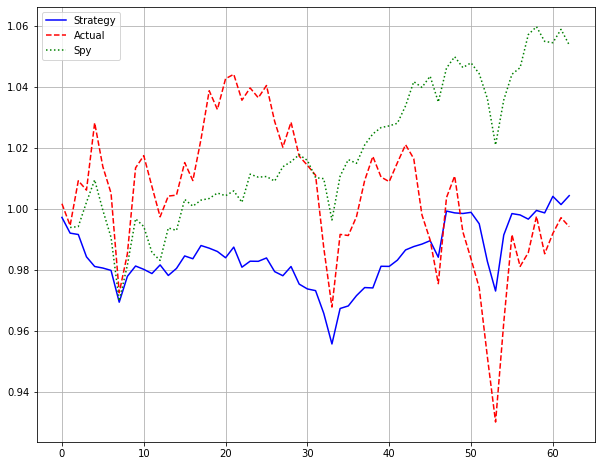

In [34]:
plt.figure(figsize=(10,8))
plt.plot(strat,'b-', label="Strategy")
plt.plot(actual,'r--', label="Actual")
plt.plot(spy,'g:', label="Spy")
plt.grid()
plt.legend()

# SMA Machine Learning Model

In [41]:
end_date

'2020-03'

In [47]:
%%time
short_win = 5
long_win = 15

weighting = 1/50

strat = np.zeros(63)

actual = np.zeros(63)

for ticker in tickers:
    
    historical = yf.Ticker(ticker).history(period="max")
    historical["return"] = historical["Close"].pct_change()
    historical["SMA_short"] = historical["Close"].rolling(window=short_win).mean().shift()
    historical["SMA_long"] = historical["Close"].rolling(window=long_win).mean().shift()
    historical["distance1"] = (historical["Close"] - historical["SMA_short"]).shift()
    historical["distance2"] = (historical["SMA_short"] - historical["SMA_long"]).shift()
    historical["distance3"] = (historical["Close"] - historical["SMA_long"]).shift()
    
    historical.dropna(inplace=True)
    
    historical_train = historical.loc[train_start:train_end].copy()
    historical_test = historical.loc[test_start:test_end].copy()
    
    scaler = StandardScaler()
    X_scaler = scaler.fit(historical_train[["SMA_short","SMA_long","distance1","distance2","distance3"]])
    X_train_scaled = X_scaler.transform(historical_train[["SMA_short","SMA_long","distance1","distance2","distance3"]])
    X_test_scaled = X_scaler.transform(historical_test[["SMA_short","SMA_long","distance1","distance2","distance3"]])
    
    svm_model = SVC()
    svm_model = svm_model.fit(X_train_scaled, np.sign(historical_train[["return"]]))
    
    historical_test["prediction"] = svm_model.predict(X_test_scaled)
    
    historical_test["strategy"] = historical_test["prediction"] * historical_test["return"]
    
    cum_ret = historical_test[["strategy","return"]].cumsum().apply(np.exp)
    
    strat = strat + np.array(cum_ret["strategy"]) * weighting
    
    actual = actual + np.array(cum_ret["return"]) * weighting
    
    print(ticker)

DISCA
DISCK
VIAC
HPQ
UAA
PWR
HWM
RJF
MHK
PTC
ENPH
NTAP
NWSA
TPR
HPE
SPG
UA
FFIV
NLSN
SIVB
WDC
NXPI
URI
AMAT
DE
IVZ
KIM
AIG
KLAC
FCX
IPG
LRCX
LUV
NWS
MS
WYNN
SLB
CFG
C
NCLH
ZBRA
MGM
AAL
ETSY
BAC
MET
GE
DVN
ALB
ALK
CPU times: user 6.03 s, sys: 390 ms, total: 6.42 s
Wall time: 31.7 s


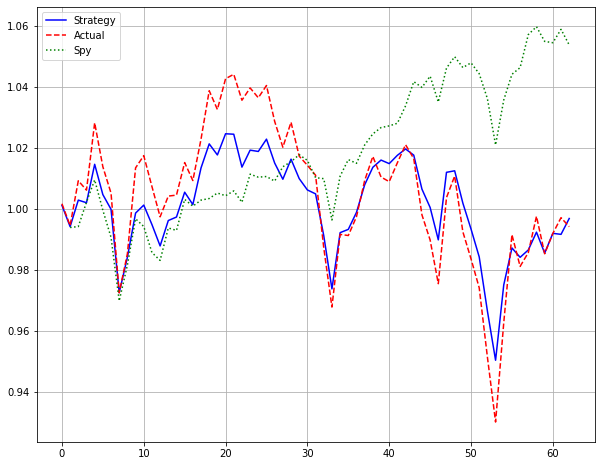

In [55]:
plt.figure(figsize=(10,8))
plt.plot(strat,'b-', label="Strategy")
plt.plot(actual,'r--', label="Actual")
plt.plot(spy,'g:', label="Spy")
plt.grid()
plt.legend()

# EMA Machine Learning Model

In [51]:
short_win = 12
long_win = 26

strat = np.zeros(63)

actual = np.zeros(63)

for ticker in tickers:
    historical = yf.Ticker(ticker).history(period="2y")
    historical["return"] = historical["Close"].pct_change()
    historical["exp1"] = historical["Close"].ewm(span=short_win, adjust=False).mean().shift()
    historical["exp2"] = historical["Close"].ewm(span=long_win, adjust=False).mean().shift()
    historical["distance1"] = (historical["Close"] - historical["exp1"]).shift()
    historical["distance2"] = (historical["Close"] - historical["exp2"]).shift()
    historical["distance3"] = (historical["exp1"] - historical["exp2"]).shift()
    historical.dropna(inplace=True)
    
    historical_train = historical.loc[train_start:train_end].copy()
    historical_test = historical.loc[test_start:test_end].copy()
    
    scaler = StandardScaler()
    X_scaler = scaler.fit(historical_train[["exp1","exp2","distance1","distance2","distance3"]])
    X_train_scaled = X_scaler.transform(historical_train[["exp1","exp2","distance1","distance2","distance3"]])
    X_test_scaled = X_scaler.transform(historical_test[["exp1","exp2","distance1","distance2","distance3"]])
    
    svm_model = SVC(C=0.5)
    svm_model = svm_model.fit(X_train_scaled, np.sign(historical_train[["return"]]))
    
    historical_test["prediction"] = svm_model.predict(X_test_scaled)
    
    historical_test["strategy"] = historical_test["prediction"] * historical_test["return"]
    
    cum_ret = historical_test[["strategy","return"]].cumsum().apply(np.exp)
    
    strat = strat + np.array(cum_ret["strategy"]) * weighting
    
    actual = actual + np.array(cum_ret["return"]) * weighting
    
    print(ticker)

DISCA
DISCK
VIAC
HPQ
UAA
PWR
HWM
RJF
MHK
PTC
ENPH
NTAP
NWSA
TPR
HPE
SPG
UA
FFIV
NLSN
SIVB
WDC
NXPI
URI
AMAT
DE
IVZ
KIM
AIG
KLAC
FCX
IPG
LRCX
LUV
NWS
MS
WYNN
SLB
CFG
C
NCLH
ZBRA
MGM
AAL
ETSY
BAC
MET
GE
DVN
ALB
ALK


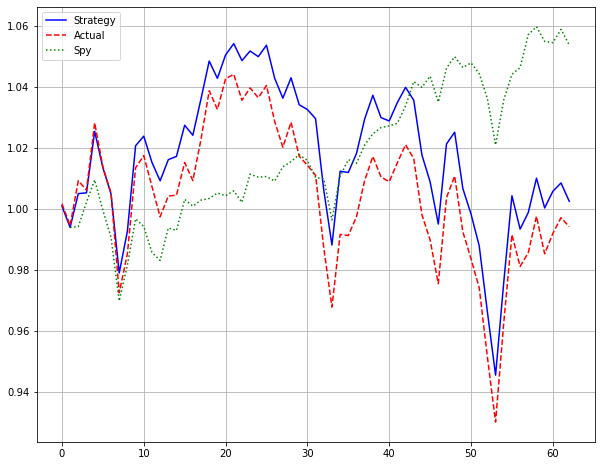

In [52]:
spy = np.array(yf.Ticker("spy").history(period="2y").loc["2021-05":"2021-07"]["Close"].pct_change().cumsum().apply(np.exp))

plt.figure(figsize=(10,8))
plt.plot(strat,'b-', label="Strategy")
plt.plot(actual,'r--', label="Actual")
plt.plot(spy,'g:', label="Spy")
plt.grid()
plt.legend()

# MACD Machine Learning Model

In [58]:
short_win = 12
long_win = 26
signal_line = 9
strat = np.zeros(63)

actual = np.zeros(63)

for ticker in tickers:
    historical = yf.Ticker(ticker).history(period="2y")
    historical["return"] = historical["Close"].pct_change()
    historical["exp1"] = historical["Close"].ewm(span=short_win, adjust=False).mean().shift()
    historical["exp2"] = historical["Close"].ewm(span=long_win, adjust=False).mean().shift()
    historical["macd"] = historical["exp1"] - historical["exp2"]
    historical["exp3"] = historical["Close"].ewm(span=signal_line, adjust=False).mean().shift()
    historical["macd_histogram"] = historical["macd"] - historical["exp3"]
    historical["lag_1"] = historical["Close"].shift()
    historical["roc"] = ((historical["Close"] - historical["lag_1"])/ historical["lag_1"]).shift()
    historical["macd_histogram_lag1"] = historical["macd_histogram"].shift()
    historical["roc_macd"] = ((historical["macd_histogram"]-historical["macd_histogram_lag1"])/historical["macd_histogram_lag1"])
    historical.dropna(inplace=True)
    
    historical_train = historical.loc[:train_end].copy()
    historical_test = historical.loc[test_start:test_end].copy()
    
    scaler = StandardScaler()
    X_scaler = scaler.fit(historical_train[["roc","roc_macd"]])
    X_train_scaled = X_scaler.transform(historical_train[["roc","roc_macd"]])
    X_test_scaled = X_scaler.transform(historical_test[["roc","roc_macd"]])
    
    svm_model = SVC(C=0.5)
    svm_model = svm_model.fit(X_train_scaled, np.sign(historical_train[["return"]]))
    
    historical_test["prediction"] = svm_model.predict(X_test_scaled)
    
    historical_test["strategy"] = historical_test["prediction"] * historical_test["return"]
    
    cum_ret = historical_test[["strategy","return"]].cumsum().apply(np.exp)
    
    strat = strat + np.array(cum_ret["strategy"]) * weighting
    
    actual = actual + np.array(cum_ret["return"]) * weighting
    
    print(ticker, accuracy_score(historical_test["prediction"],
                                np.sign(historical_test["return"])))

DISCA 0.4603174603174603
DISCK 0.36507936507936506
VIAC 0.47619047619047616
HPQ 0.5873015873015873
UAA 0.3968253968253968
PWR 0.4444444444444444
HWM 0.49206349206349204
RJF 0.5555555555555556
MHK 0.3968253968253968
PTC 0.5873015873015873
ENPH 0.5238095238095238
NTAP 0.5555555555555556
NWSA 0.4603174603174603
TPR 0.47619047619047616
HPE 0.47619047619047616
SPG 0.47619047619047616
UA 0.4603174603174603
FFIV 0.5238095238095238
NLSN 0.49206349206349204
SIVB 0.5396825396825397
WDC 0.4603174603174603
NXPI 0.5555555555555556
URI 0.5238095238095238
AMAT 0.6190476190476191
DE 0.4444444444444444
IVZ 0.47619047619047616
KIM 0.4603174603174603
AIG 0.5079365079365079
KLAC 0.5714285714285714
FCX 0.42857142857142855
IPG 0.5873015873015873
LRCX 0.5396825396825397
LUV 0.3333333333333333
NWS 0.4444444444444444
MS 0.5714285714285714
WYNN 0.6349206349206349
SLB 0.5079365079365079
CFG 0.4603174603174603
C 0.4126984126984127
NCLH 0.3968253968253968
ZBRA 0.4603174603174603
MGM 0.42857142857142855
AAL 0.42857

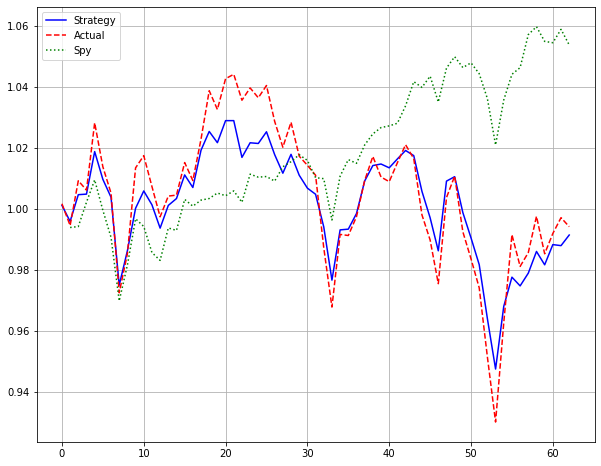

In [59]:
plt.figure(figsize=(10,8))
plt.plot(strat,'b-', label="Strategy")
plt.plot(actual,'r--', label="Actual")
plt.plot(spy,'g:', label="Spy")
plt.grid()
plt.legend()